<a href="https://colab.research.google.com/github/apanand/UChicago-MSADS/blob/main/Spotify%20Recommender/Spotify_Recommender_Neural_Network_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
from numpy import argmax
import pandas as pd
from collections import Counter
from datetime import datetime
import os
import itertools
import math
import collections

# Plotting
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# !pip install ipyplot
# !pip install jupyter-dash
import seaborn as sns
import matplotlib.pyplot as plt

# ## Neural Network
# #!pip install tensorflow
# import tensorflow as tf
# from tensorflow.keras.activations import relu, sigmoid, softmax, tanh, selu, elu
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
# from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
# !pip install tensorflow_addons
# from tensorflow.keras.constraints import MaxNorm
# from tensorflow.keras.regularizers import l2, l1
# from tensorboard.plugins.hparams import api as hp
# !pip install keras-tuner
# import kerastuner as kt
# !pip install tensorflow_addons
# import tensorflow_addons as tfa
# !pip install scikeras[tensorflow]
# from scikeras.wrappers import KerasClassifier, KerasRegressor
# import keras_tuner

# Spotify
! pip3 install spotipy
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyOAuth


# SkLearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 6.2 MB/s eta 0:00:00


# **Wrangling my Listening Data**

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving StreamingHistory_music_0.json to StreamingHistory_music_0.json
Saving StreamingHistory_music_1.json to StreamingHistory_music_1.json
Saving StreamingHistory_music_2.json to StreamingHistory_music_2.json
Saving StreamingHistory_music_3.json to StreamingHistory_music_3.json


In [ ]:
import pandas as pd
import json

def load_and_merge_json_files(file_paths):
    # Initialize an empty list to hold DataFrames
    dataframes = []

    # Loop through each file path and read the JSON file into a DataFrame
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            df = pd.DataFrame(data)
            dataframes.append(df)

    # Concatenate all DataFrames into a single DataFrame
    merged_df = pd.concat(dataframes, ignore_index=True)

    return merged_df

##Example usage:
file_paths = ['StreamingHistory_music_0.json', 'StreamingHistory_music_1.json', 'StreamingHistory_music_2.json', 'StreamingHistory_music_3.json']
merged_df = load_and_merge_json_files(file_paths)
print(merged_df)

                endTime      artistName  \
0      2023-05-18 00:02     JACK MARLOW   
1      2023-05-18 00:03         Kartoon   
2      2023-05-18 02:04          salute   
3      2023-05-18 03:05    TECH IT DEEP   
4      2023-05-18 03:10  Shaolin Cowboy   
...                 ...             ...   
33437  2024-05-18 23:56    Flipp Dinero   
33438  2024-05-18 23:56          Future   
33439  2024-05-18 23:56    Lil Uzi Vert   
33440  2024-05-18 23:56         J. Cole   
33441  2024-05-18 23:57           Gunna   

                                       trackName  msPlayed  
0                                     Flyin Baby    192000  
1      Soundboy Surrender - Crossy Remix - Mixed     61714  
2                                          Peach    345310  
3                                    Maria Maria     31151  
4                        Réveiller (feat. manon)    289787  
...                                          ...       ...  
33437                             Leave Me Alone      32

In [ ]:
merged_df

,endTime,artistName,trackName,msPlayed
0,2023-05-18 00:02,JACK MARLOW,Flyin Baby,192000
1,2023-05-18 00:03,Kartoon,Soundboy Surrender - Crossy Remix - Mixed,61714
2,2023-05-18 02:04,salute,Peach,345310
3,2023-05-18 03:05,TECH IT DEEP,Maria Maria,31151
4,2023-05-18 03:10,Shaolin Cowboy,Réveiller (feat. manon),289787
...,...,...,...,...
33437,2024-05-18 23:56,Flipp Dinero,Leave Me Alone,3200
33438,2024-05-18 23:56,Future,Mask Off (feat. Kendrick Lamar) - Remix,5116
33439,2024-05-18 23:56,Lil Uzi Vert,New Patek,3480
33440,2024-05-18 23:56,J. Cole,MIDDLE CHILD,1200


In [ ]:
merged_df.value_counts()

endTime           artistName          trackName                        msPlayed
2023-05-18 00:02  JACK MARLOW         Flyin Baby                       192000      1
2024-02-28 18:48  Magic City Hippies  Ghost On The Mend - veggi remix  88526       1
2024-02-28 16:07  Unknown T           Goodums - Sammy Virji Remix      9088        1
                  Sammy Virji         Find My Way Home                 6816        1
                  RAC                 Passion                          3455        1
                                                                                  ..
2023-10-24 19:06  Oppidan             Rosalina                         169411      1
2023-10-24 19:03  JEV                 DREAMER                          133846      1
2023-10-24 19:01  MPH                 Spend The Night                  210909      1
2023-10-24 18:58  Conducta            Alone - Mixed                    112923      1
2024-05-18 23:57  Gunna               Drip or Drown                   

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33442 entries, 0 to 33441
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   endTime     33442 non-null  object
 1   artistName  33442 non-null  object
 2   trackName   33442 non-null  object
 3   msPlayed    33442 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


In [ ]:
merged_df = merged_df.drop_duplicates(subset=['trackName', 'artistName'])
merged_df


,endTime,artistName,trackName,msPlayed
0,2023-05-18 00:02,JACK MARLOW,Flyin Baby,192000
1,2023-05-18 00:03,Kartoon,Soundboy Surrender - Crossy Remix - Mixed,61714
2,2023-05-18 02:04,salute,Peach,345310
3,2023-05-18 03:05,TECH IT DEEP,Maria Maria,31151
4,2023-05-18 03:10,Shaolin Cowboy,Réveiller (feat. manon),289787
...,...,...,...,...
33416,2024-05-18 23:52,m$sha,OOPS,900
33418,2024-05-18 23:52,CALIsthenics,"Paper Thick (feat. E-40, Casual & Del the Funk...",1330
33421,2024-05-18 23:52,Chris Mula,Go To Work,620
33428,2024-05-18 23:56,Travis Scott,Oh My Dis Side (feat. Quavo),940


# Connecting to Spotify API to get Song ID's and Features

In [60]:
#@title Spotify Developer Credentials { run: "auto", vertical-output: true, display-mode: "form" }
SPOTIFY_CLIENT_ID = "63491f3b28294698834a8596f0ae0a22" #@param {type:"string"}
SPOTIFY_CLIENT_SECRET = "9c708402905d434d83b87657eef5d30b" #@param {type:"string"}
SPOTIFY_REDIRECT_URI = 'https://www.google.com/'
SCOPE = "playlist-modify-public playlist-read-collaborative playlist-modify-private"
scope = "user-read-recently-played"
assert len(SPOTIFY_CLIENT_ID)>0, 'Please provide a spotify client id'
assert len(SPOTIFY_CLIENT_SECRET)>0, 'Please provide a spotify client secret code'

sp = spotipy.Spotify(
    auth_manager=spotipy.SpotifyOAuth(
        client_id=SPOTIFY_CLIENT_ID,
        client_secret=SPOTIFY_CLIENT_SECRET,
        redirect_uri=SPOTIFY_REDIRECT_URI,
        scope=SCOPE, open_browser=False),
        requests_timeout=20, retries=10)
form_conn = sp.artist('spotify:artist:3jOstUTkEu2JkjvRdBA5Gu')

print('Authorization Sucessful!')

Authorization Sucessful!


In [ ]:
import time
from tqdm import tqdm

def get_track_id(artist_name, track_name):
    query = f"artist:{artist_name} track:{track_name}"
    while True:
        try:
            result = sp.search(q=query, type='track', limit=1)
            tracks = result.get('tracks', {}).get('items', [])
            if tracks:
                return tracks[0]['id']
            return None
        except spotipy.SpotifyException as e:
            if e.http_status == 429:  # Rate limit status code
                retry_after = int(e.headers.get('Retry-After', 60))
                print(f"Rate limit exceeded. Sleeping for {retry_after} seconds.")
                time.sleep(retry_after)
            else:
                print(f"SpotifyException: {e}")
                return None
        except requests.exceptions.RequestException as e:
            print(f"RequestException: {e}")
            time.sleep(5)  # Wait for a short time before retrying
        except Exception as e:
            print(f"Unexpected error: {e}")
            return None

# Assuming your DataFrame is named `df`
# Initialize an empty list to store track IDs
track_ids = []

# Loop through the DataFrame with a progress bar and handle rate limits
for _, row in tqdm(merged_df.iterrows(), total=merged_df.shape[0], desc="Fetching track IDs"):
    track_id = get_track_id(row['artistName'], row['trackName'])
    track_ids.append(track_id)
    time.sleep(0.5)  # Add a delay to avoid hitting the rate limit too quickly

# Assign the track IDs back to the DataFrame
merged_df['track_id'] = track_ids


# def get_track_id(artist_name, track_name):
#     query = f"artist:{artist_name} track:{track_name}"
#     result = sp.search(q=query, type='track', limit=1)
#     tracks = result.get('tracks', {}).get('items', [])
#     if tracks:
#         return tracks[0]['id']
#     return None

# # Apply the get_track_id function with a progress bar
# merged_df['track_id'] = [get_track_id(row['artistName'], row['trackName']) for _, row in tqdm(merged_df.iterrows(), total=merged_df.shape[0], desc="Fetching track IDs")]

# time.sleep(1)


Fetching track IDs:   5%|▍         | 387/8380 [04:48<1:39:21,  1.34it/s]


KeyboardInterrupt: 

In [ ]:
merged_df.to_csv('merged_df.csv', index=False)

from google.colab import files
files.download("merged_df.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
from google.colab import files

uploaded = files.upload()

Saving merged_df.csv to merged_df.csv


In [7]:
merged_df = pd.read_csv('merged_df.csv')

In [8]:
merged_df

,endTime,artistName,trackName,msPlayed,track_id
0,2023-05-18 00:02,JACK MARLOW,Flyin Baby,192000,597vP6rhNkEpSHpCyriFnf
1,2023-05-18 00:03,Kartoon,Soundboy Surrender - Crossy Remix - Mixed,61714,3cEvwcgCxyMKIKFp37LGwS
2,2023-05-18 02:04,salute,Peach,345310,5cGZN0P1QnSfhCFBCHtp2N
3,2023-05-18 03:05,TECH IT DEEP,Maria Maria,31151,4wP6mzWZC94dYmU6OYeljf
4,2023-05-18 03:10,Shaolin Cowboy,Réveiller (feat. manon),289787,51oib6a2dRu2f6x8OMMphQ
...,...,...,...,...,...
8375,2024-05-18 23:52,m$sha,OOPS,900,4UBIs1W680L7JR7oqkx3zq
8376,2024-05-18 23:52,CALIsthenics,"Paper Thick (feat. E-40, Casual & Del the Funk...",1330,4uSsR7XGqmC4F8ngY65I2M
8377,2024-05-18 23:52,Chris Mula,Go To Work,620,3AwQtBfYQgDLfMnQ8ZNkEt
8378,2024-05-18 23:56,Travis Scott,Oh My Dis Side (feat. Quavo),940,2rMFawCg4BW65jzbwztXAV


In [9]:
track_ids = merged_df['track_id']

In [10]:
track_ids

0       597vP6rhNkEpSHpCyriFnf
1       3cEvwcgCxyMKIKFp37LGwS
2       5cGZN0P1QnSfhCFBCHtp2N
3       4wP6mzWZC94dYmU6OYeljf
4       51oib6a2dRu2f6x8OMMphQ
                 ...          
8375    4UBIs1W680L7JR7oqkx3zq
8376    4uSsR7XGqmC4F8ngY65I2M
8377    3AwQtBfYQgDLfMnQ8ZNkEt
8378    2rMFawCg4BW65jzbwztXAV
8379    6nO3tr47nr2P7f3hXb8JIo
Name: track_id, Length: 8380, dtype: object

In [14]:
import sys
from tqdm import tqdm



def get_track_details_and_features(sp, track_ids):
    details_list = []

    for i in tqdm(range(0, len(track_ids), 50), desc="Fetching track details and features"):
        batch = track_ids[i:i + 50]
        retries = 0
        while True:
            try:
                # Fetch track details
                tracks = sp.tracks(batch)['tracks']
                # Fetch track features
                features_list = sp.audio_features(batch)

                # Combine track details and features
                for track, features in zip(tracks, features_list):
                    if track and features:  # Ensure there are track details and features
                        details = {
                            'id': track['id'],
                            'title': track['name'],
                            'all_artists': ', '.join([artist['name'] for artist in track['artists']]),
                            'popularity': track['popularity'],
                            'release_date': track['album']['release_date'],
                            'danceability': features['danceability'],
                            'energy': features['energy'],
                            'key': features['key'],
                            'loudness': features['loudness'],
                            'mode': features['mode'],
                            'acousticness': features['acousticness'],
                            'instrumentalness': features['instrumentalness'],
                            'liveness': features['liveness'],
                            'valence': features['valence'],
                            'tempo': features['tempo'],
                            'duration_ms': features['duration_ms'],
                            'time_signature': features['time_signature']
                        }
                        details_list.append(details)
                break  # Exit the retry loop if the call is successful
            except spotipy.SpotifyException as e:
                if e.http_status == 429:  # Rate limit status code
                    retries += 1
                    retry_after = min(int(e.headers.get('Retry-After', 60)), 2 ** retries)
                    print(f"Rate limit exceeded. Sleeping for {retry_after} seconds. Retry #{retries}", file=sys.stderr)
                    time.sleep(retry_after)
                else:
                    print(f"SpotifyException: {e}", file=sys.stderr)
                    break
            except requests.exceptions.RequestException as e:
                print(f"RequestException: {e}", file=sys.stderr)
                time.sleep(5)  # Wait for a short time before retrying
            except Exception as e:
                print(f"Unexpected error: {e}", file=sys.stderr)
                break
    return details_list

In [15]:
track_ids = merged_df['track_id'].dropna().tolist()

# Fetch details and features
track_details = get_track_details_and_features(sp, track_ids)

# Convert the list of details into a DataFrame
details_df = pd.DataFrame(track_details)


Fetching track details and features: 100%|██████████| 163/163 [01:09<00:00,  2.33it/s]


In [21]:
details_df

,id,title,all_artists,popularity,release_date,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,597vP6rhNkEpSHpCyriFnf,Flyin Baby,JACK MARLOW,39,2023-04-21,0.826,0.576,9,-10.317,0,0.0165,0.747000,0.1340,0.670,129.980,192000,4
1,3cEvwcgCxyMKIKFp37LGwS,Soundboy Surrender - Crossy Remix - Mixed,"Kartoon, Crossy",55,2022-07-22,0.530,0.856,10,-2.220,0,0.0176,0.351000,0.2450,0.718,87.513,61714,4
2,5cGZN0P1QnSfhCFBCHtp2N,Peach,"salute, Sammy Virji",55,2023-03-31,0.866,0.668,1,-7.472,1,0.0115,0.889000,0.2380,0.657,135.009,345311,4
3,4wP6mzWZC94dYmU6OYeljf,Maria Maria,TECH IT DEEP,69,2023-02-08,0.723,0.685,0,-6.790,1,0.0992,0.000601,0.2440,0.386,127.987,161802,4
4,51oib6a2dRu2f6x8OMMphQ,Réveiller (feat. manon),"Shaolin Cowboy, manon",52,2021-03-26,0.842,0.418,8,-9.602,0,0.7650,0.022800,0.1170,0.448,128.009,289787,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8095,4UBIs1W680L7JR7oqkx3zq,OOPS,"m$sha, Jay Critch",42,2023-03-17,0.790,0.652,3,-6.882,0,0.0325,0.000041,0.0769,0.253,140.399,117447,4
8096,4uSsR7XGqmC4F8ngY65I2M,"Paper Thick (feat. E-40, Casual & Del the Funk...","CALIsthenics, E-40, Casual, Del The Funky Homo...",32,2024-03-29,0.770,0.770,11,-6.348,0,0.0177,0.005410,0.3220,0.261,104.105,124824,4
8097,3AwQtBfYQgDLfMnQ8ZNkEt,Go To Work,Chris Mula,66,2023-10-17,0.509,0.540,9,-13.219,1,0.5210,0.000000,0.4570,0.152,67.770,116286,4
8098,2rMFawCg4BW65jzbwztXAV,Oh My Dis Side (feat. Quavo),"Travis Scott, Quavo",66,2015-09-04,0.459,0.623,1,-4.450,1,0.3520,0.000000,0.1310,0.205,126.014,351253,4


In [19]:
details_df.to_csv('listening_history.csv', index=False)

from google.colab import files
files.download("listening_history.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Get Billboard Top 100 Data and Features

In [61]:
def get_playlist_tracks(sp, playlist_id):
    tracks = []
    results = sp.playlist_tracks(playlist_id)
    while results:
        tracks.extend([item['track'] for item in results['items'] if item['track']])
        results = sp.next(results) if results['next'] else None
    return tracks


def get_track_details_and_features(sp, tracks):
    track_ids = [track['id'] for track in tracks if track['id']]
    features_list = sp.audio_features(track_ids)

    details_list = []
    for track, features in zip(tracks, features_list):
        if features:  # Ensure there are features
            details = {
                'id': track['id'],
                'title': track['name'],
                'all_artists': ', '.join([artist['name'] for artist in track['artists']]),
                'popularity': track['popularity'],
                'release_date': track['album']['release_date'],
                'danceability': features['danceability'],
                'energy': features['energy'],
                'key': features['key'],
                'loudness': features['loudness'],
                'mode': features['mode'],
                'acousticness': features['acousticness'],
                'instrumentalness': features['instrumentalness'],
                'liveness': features['liveness'],
                'valence': features['valence'],
                'tempo': features['tempo'],
                'duration_ms': features['duration_ms'],
                'time_signature': features['time_signature']
            }
            details_list.append(details)
    return details_list

billboard_playlist_id = '1G8IpkZKobrIlXcVPoSIuf'  # Replace with the actual ID
billboard_tracks = get_playlist_tracks(sp, billboard_playlist_id)
track_details = get_track_details_and_features(sp, billboard_tracks)

# Convert the list of details to a DataFrame
billboard_features_df = pd.DataFrame(track_details)
billboard_features_df.head()

KeyboardInterrupt: 

In [23]:
features_df = details_df

In [2]:
from google.colab import files

uploaded = files.upload()

Saving listening_history.csv to listening_history.csv
Saving billboard_features_df.csv to billboard_features_df.csv


In [3]:
billboard_features_df = pd.read_csv('billboard_features_df.csv')

In [4]:
features_df = pd.read_csv('listening_history.csv')

# Exploratory Data Analysis

In [5]:
features_df

,id,title,all_artists,popularity,release_date,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,597vP6rhNkEpSHpCyriFnf,Flyin Baby,JACK MARLOW,39,2023-04-21,0.826,0.576,9,-10.317,0,0.0165,0.747000,0.1340,0.670,129.980,192000,4
1,3cEvwcgCxyMKIKFp37LGwS,Soundboy Surrender - Crossy Remix - Mixed,"Kartoon, Crossy",55,2022-07-22,0.530,0.856,10,-2.220,0,0.0176,0.351000,0.2450,0.718,87.513,61714,4
2,5cGZN0P1QnSfhCFBCHtp2N,Peach,"salute, Sammy Virji",55,2023-03-31,0.866,0.668,1,-7.472,1,0.0115,0.889000,0.2380,0.657,135.009,345311,4
3,4wP6mzWZC94dYmU6OYeljf,Maria Maria,TECH IT DEEP,69,2023-02-08,0.723,0.685,0,-6.790,1,0.0992,0.000601,0.2440,0.386,127.987,161802,4
4,51oib6a2dRu2f6x8OMMphQ,Réveiller (feat. manon),"Shaolin Cowboy, manon",52,2021-03-26,0.842,0.418,8,-9.602,0,0.7650,0.022800,0.1170,0.448,128.009,289787,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8095,4UBIs1W680L7JR7oqkx3zq,OOPS,"m$sha, Jay Critch",42,2023-03-17,0.790,0.652,3,-6.882,0,0.0325,0.000041,0.0769,0.253,140.399,117447,4
8096,4uSsR7XGqmC4F8ngY65I2M,"Paper Thick (feat. E-40, Casual & Del the Funk...","CALIsthenics, E-40, Casual, Del The Funky Homo...",32,2024-03-29,0.770,0.770,11,-6.348,0,0.0177,0.005410,0.3220,0.261,104.105,124824,4
8097,3AwQtBfYQgDLfMnQ8ZNkEt,Go To Work,Chris Mula,66,2023-10-17,0.509,0.540,9,-13.219,1,0.5210,0.000000,0.4570,0.152,67.770,116286,4
8098,2rMFawCg4BW65jzbwztXAV,Oh My Dis Side (feat. Quavo),"Travis Scott, Quavo",66,2015-09-04,0.459,0.623,1,-4.450,1,0.3520,0.000000,0.1310,0.205,126.014,351253,4


In [8]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8100 entries, 0 to 8099
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8100 non-null   object 
 1   title             8100 non-null   object 
 2   all_artists       8100 non-null   object 
 3   popularity        8100 non-null   int64  
 4   release_date      8100 non-null   object 
 5   danceability      8100 non-null   float64
 6   energy            8100 non-null   float64
 7   key               8100 non-null   int64  
 8   loudness          8100 non-null   float64
 9   mode              8100 non-null   int64  
 10  acousticness      8100 non-null   float64
 11  instrumentalness  8100 non-null   float64
 12  liveness          8100 non-null   float64
 13  valence           8100 non-null   float64
 14  tempo             8100 non-null   float64
 15  duration_ms       8100 non-null   int64  
 16  time_signature    8100 non-null   int64  


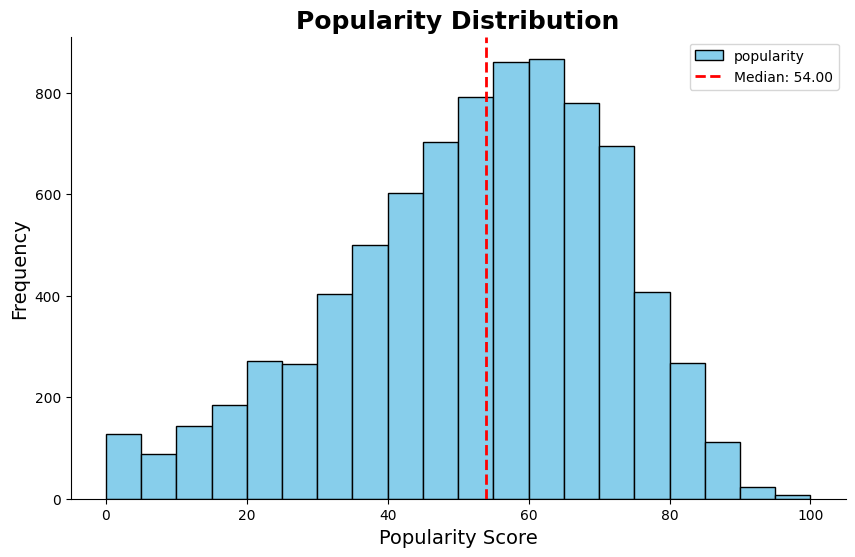

In [20]:
import matplotlib.pyplot as plt

median_popularity = features_df['popularity'].median()


# Assume features_df is a DataFrame and 'popularity' is a column in it
# Generate the histogram
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
features_df['popularity'].plot(
    kind='hist',
    bins=20,
    color='skyblue',  # Choose a pleasant color
    edgecolor='black'  # Add edge color to the bins for better distinction
)

plt.title('Popularity Distribution', fontsize=18, weight = 'bold')  # Set title and font size
plt.xlabel('Popularity Score', fontsize=14)  # Label the x-axis
plt.ylabel('Frequency', fontsize=14)  # Label the y-axis
plt.grid(False)  # Add gridlines
plt.gca().spines['top'].set_visible(False)  # Hide the top spine
plt.gca().spines['right'].set_visible(False)  # Hide the right spine

plt.axvline(x=median_popularity, color='red', linestyle='--', linewidth=2, label=f'Median: {median_popularity:.2f}')
plt.legend()  # Show legend to explain the line
plt.show()  # Display the plot


In [18]:
features_df['popularity'].median()

54.0

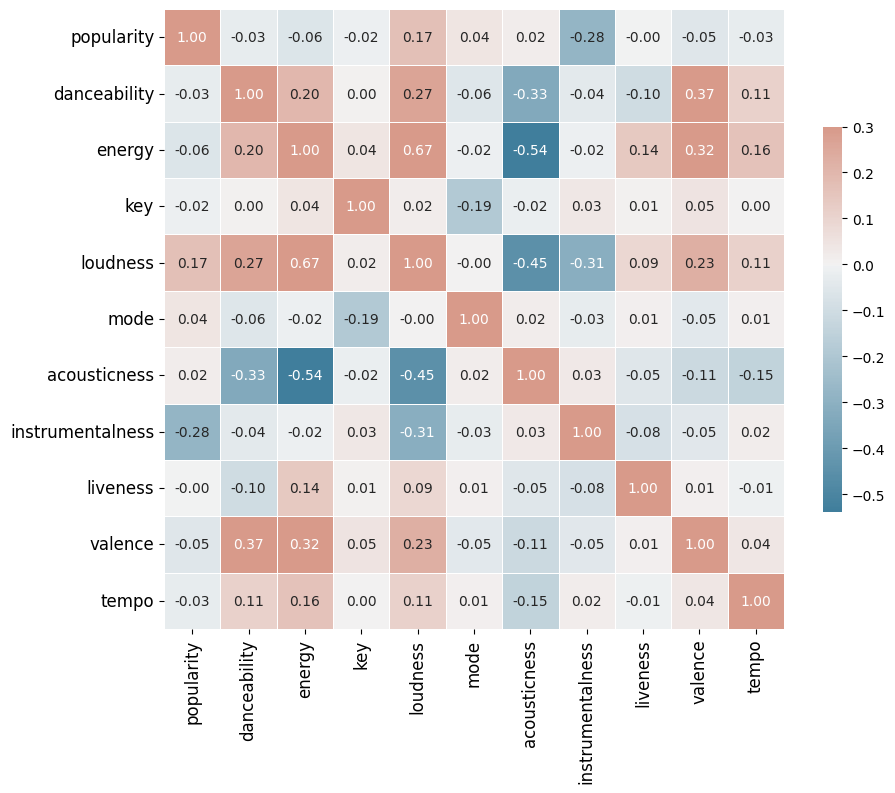

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming features_df is your DataFrame

# Filter out non-numerical columns
numerical_df = features_df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
feature_columns = [
    'popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
    'acousticness', 'instrumentalness', 'liveness', 'valence',
    'tempo'
]
corr_matrix = features_df[feature_columns].corr()
# Set up the matplotlib figure
plt.figure(figsize=(10, 10))  # Set the size of the heatmap

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

# Add title and possibly some more customization for aesthetics
plt.xticks(fontsize=12)  # Adjust font size for x-axis labels
plt.yticks(fontsize=12)  # Adjust font size for y-axis labels

plt.show()


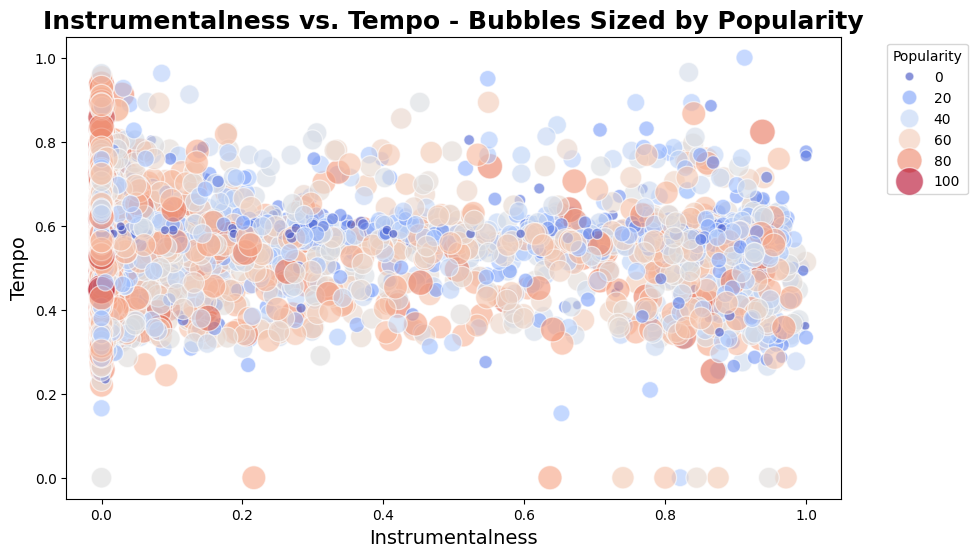

In [120]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='instrumentalness', y='tempo', hue='popularity', size='popularity', data=features_df, palette='coolwarm', sizes=(40, 400), alpha=0.6)
plt.title('Instrumentalness vs. Tempo - Bubbles Sized by Popularity', fontsize = 18, weight = 'bold')
plt.xlabel('Instrumentalness', fontsize = 14)
plt.ylabel('Tempo', fontsize = 14)
plt.legend(title='Popularity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


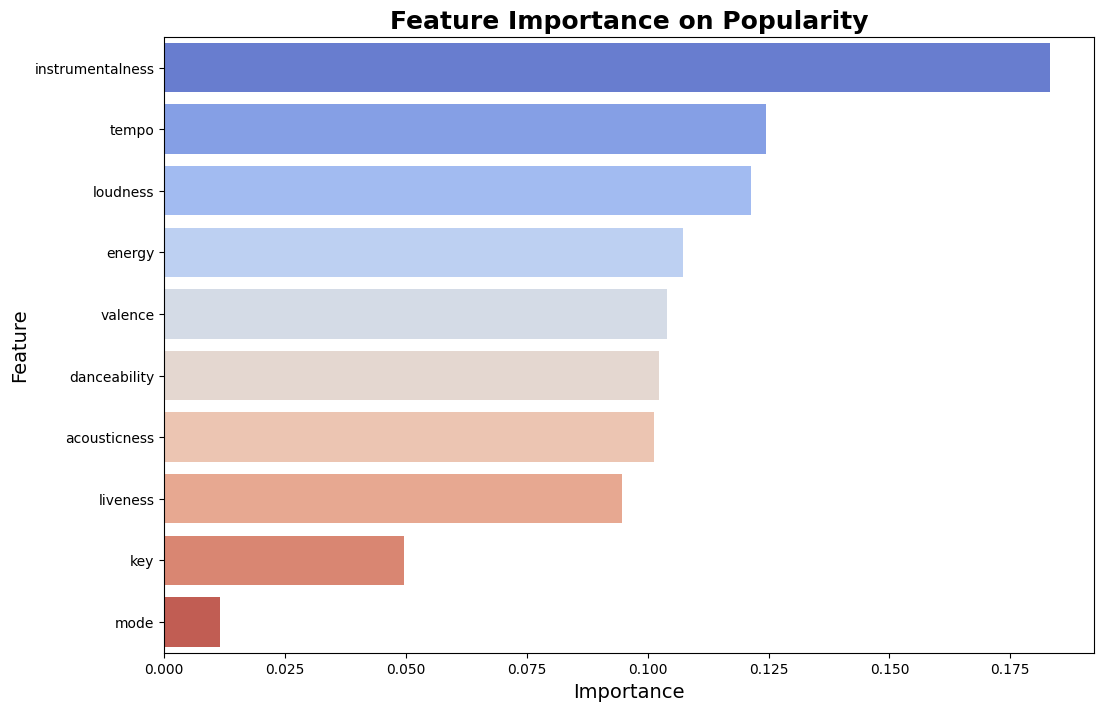

In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Load the features_df dataframe
# Assuming features_df is already loaded and preprocessed
# features_df = pd.read_csv("path_to_your_dataset.csv")

# Extract features and target
features = ['danceability', 'energy', 'key', 'loudness', 'mode',
    'acousticness', 'instrumentalness', 'liveness', 'valence',
    'tempo']
X = features_df[features]
y = features_df['popularity']

# Train a Random Forest model to determine feature importances
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot for feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='coolwarm')
plt.title('Feature Importance on Popularity', fontsize = 18, weight = 'semibold')
plt.xlabel('Importance', fontsize = 14)
plt.ylabel('Feature', fontsize = 14)
plt.savefig('feature_importance.png', bbox_inches='tight')
plt.show()

# Prepare for Modeling

In [6]:
features_df['rating'] = 1

In [7]:
billboard_features_df['rating'] = 0

In [37]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load DataFrames (assuming 'features_df' and 'billboard_features_df' are already loaded)
# with energy removed based on EDA correlation matrix results
features = ['danceability', 'key', 'mode' , 'loudness', 'acousticness',
            'instrumentalness', 'liveness', 'valence',
            'tempo', 'duration_ms', 'time_signature']

# Normalize feature data
scaler = MinMaxScaler()
features_df[features] = scaler.fit_transform(features_df[features])
billboard_features_df[features] = scaler.transform(billboard_features_df[features])

# Prepare the target by binarizing the popularity (above median popularity)
median_popularity = features_df['popularity'].median()
features_df['target'] = (features_df['popularity'] > median_popularity).astype(int)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(features_df[features], features_df['target'], test_size=0.2, random_state=42)

In [39]:
y_train.value_counts()

target
0    3279
1    3201
Name: count, dtype: int64

# Baseline Model - Content Based Recommender

In [40]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between the songs in the training set and the Billboard songs
similarity_matrix = cosine_similarity(X_train, billboard_features_df[features])

# Get the indices of the most similar Billboard songs for each song in the training set
most_similar_indices = np.argmax(similarity_matrix, axis=1)

# Get the recommended songs
recommended_songs = billboard_features_df.iloc[most_similar_indices].reset_index(drop=True)

# Prepare the target by binarizing the popularity of the recommended songs
def evaluate_recommendations(recommended_songs, y_train):
    recommended_popularity = recommended_songs['popularity']
    recommended_target = (recommended_popularity > median_popularity).astype(int)
    y_train = y_train.reset_index(drop=True)  # Ensure the indices match
    accuracy = np.mean(recommended_target == y_train)
    return accuracy

content_based_accuracy = evaluate_recommendations(recommended_songs, y_train)
print(f"Content-Based Recommender Accuracy: {content_based_accuracy}")


recommended_songs = recommended_songs.sort_values('predicted_like', ascending=False).drop_duplicates('id').sort_values('predicted_like', ascending=False)

recommended_songs

Content-Based Recommender Accuracy: 0.49398148148148147


,id,title,all_artists,popularity,release_date,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,rating,predicted_like
1097,6uTPdRrEDeH8Fyg5L5qmeU,Never Lose Me,Flo Milli,83,2023-11-30,0.803339,0.571580,0.008264,0.987566,1.0,0.050896,0.000000,0.068743,0.077364,0.002257,-0.007163,0.16,0,0.641717
2239,28drn6tQo95MRvO0jQEo5C,Type Shit,"Future, Metro Boomin, Travis Scott, Playboi Carti",91,2024-03-22,0.658306,0.556315,0.016529,0.989057,1.0,0.021704,0.000000,0.091027,0.116618,0.002682,-0.007163,0.16,0,0.640622
3908,4KULAymBBJcPRpk1yO4dOG,I Remember Everything (feat. Kacey Musgraves),"Zach Bryan, Kacey Musgraves",91,2023-08-25,0.441271,0.455570,0.000000,0.987641,1.0,0.559577,0.000002,0.072901,0.161391,0.001437,-0.007163,0.16,0,0.639547
2156,7CyPwkp0oE8Ro9Dd5CUDjW,"One Of The Girls (with JENNIE, Lily Rose Depp)","The Weeknd, JENNIE, Lily-Rose Depp",94,2023-06-23,0.271551,0.645866,0.066116,0.988686,1.0,0.039684,0.000002,0.125146,0.197834,0.001570,-0.007163,0.16,0,0.639524
5149,1kbEbBdEgQdQeLXCJh28pJ,Down Bad,Taylor Swift,91,2024-04-19,0.556474,0.367037,0.090909,0.985816,1.0,0.565637,0.000001,0.065011,0.174927,0.002955,-0.007163,0.16,0,0.636723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,1nQaTUDJ7Rc4yOvZmg9Ozr,Mmhmm,BigXthaPlug,74,2023-10-06,0.956601,0.688607,0.074380,0.986921,1.0,0.028270,0.000000,0.101689,1.001667,0.002331,-0.007163,0.16,0,0.496226
5111,2Zo1PcszsT9WQ0ANntJbID,Feather,Sabrina Carpenter,90,2023-03-17,0.813625,0.700818,0.049587,0.989979,0.0,0.074330,0.000002,0.066291,0.860059,0.002285,-0.007163,0.16,0,0.494399
6,7fzHQizxTqy8wTXwlrgPQQ,MILLION DOLLAR BABY,Tommy Richman,97,2024-04-26,0.873284,0.705906,0.008264,0.989449,0.0,0.099178,0.000220,0.036650,0.965224,0.002553,-0.007163,0.16,0,0.487898
4859,1fAeFPXsX08Ovnn9iV1x27,Halfway To Hell,Jelly Roll,73,2023-06-02,0.517388,0.873814,0.016529,0.989264,0.0,0.002280,0.000000,0.974928,0.461267,0.001983,-0.007163,0.16,0,0.478755


In [41]:
similarity_matrix_train = cosine_similarity(X_train, billboard_features_df[features])
similarity_matrix_test = cosine_similarity(X_test, billboard_features_df[features])

# Get the indices of the most similar Billboard songs for each song in the training set
most_similar_indices_train = np.argmax(similarity_matrix_train, axis=1)
most_similar_indices_test = np.argmax(similarity_matrix_test, axis=1)

# Get the recommended songs
recommended_songs_train = billboard_features_df.iloc[most_similar_indices_train].reset_index(drop=True)
recommended_songs_test = billboard_features_df.iloc[most_similar_indices_test].reset_index(drop=True)

# Prepare the target by binarizing the popularity of the recommended songs
def evaluate_recommendations(recommended_songs, y_true):
    recommended_popularity = recommended_songs['popularity']
    recommended_target = (recommended_popularity > median_popularity).astype(int)
    y_true = y_true.reset_index(drop=True)  # Ensure the indices match
    accuracy = np.mean(recommended_target == y_true)
    return accuracy

# Evaluate performance
train_accuracy = evaluate_recommendations(recommended_songs_train, y_train)
test_accuracy = evaluate_recommendations(recommended_songs_test, y_test)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")


Train Accuracy: 0.49398148148148147
Test Accuracy: 0.5061728395061729


In [42]:
features_df

,id,title,all_artists,popularity,release_date,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,rating,target
0,597vP6rhNkEpSHpCyriFnf,Flyin Baby,JACK MARLOW,39,2023-04-21,0.836032,0.576,0.818182,0.749155,0.0,0.016561,0.758376,0.123764,0.682977,0.580631,0.047358,0.8,1,0
1,3cEvwcgCxyMKIKFp37LGwS,Soundboy Surrender - Crossy Remix - Mixed,"Kartoon, Crossy",55,2022-07-22,0.536437,0.856,0.909091,0.923483,0.0,0.017665,0.356345,0.238056,0.731906,0.390927,0.010361,0.8,1,1
2,5cGZN0P1QnSfhCFBCHtp2N,Peach,"salute, Sammy Virji",55,2023-03-31,0.876518,0.668,0.090909,0.810408,1.0,0.011541,0.902538,0.230848,0.669725,0.603096,0.090894,0.8,1,1
3,4wP6mzWZC94dYmU6OYeljf,Maria Maria,TECH IT DEEP,69,2023-02-08,0.731781,0.685,0.000000,0.825091,1.0,0.099594,0.000610,0.237026,0.393476,0.571728,0.038783,0.8,1,1
4,51oib6a2dRu2f6x8OMMphQ,Réveiller (feat. manon),"Shaolin Cowboy, manon",52,2021-03-26,0.852227,0.418,0.727273,0.764549,0.0,0.768071,0.023147,0.106260,0.456677,0.571826,0.075127,0.8,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8095,4UBIs1W680L7JR7oqkx3zq,OOPS,"m$sha, Jay Critch",42,2023-03-17,0.799595,0.652,0.272727,0.823110,0.0,0.032625,0.000041,0.064971,0.257900,0.627173,0.026188,0.8,1,0
8096,4uSsR7XGqmC4F8ngY65I2M,"Paper Thick (feat. E-40, Casual & Del the Funk...","CALIsthenics, E-40, Casual, Del The Funky Homo...",32,2024-03-29,0.779352,0.770,1.000000,0.834607,0.0,0.017766,0.005492,0.317339,0.266055,0.465045,0.028283,0.8,1,0
8097,3AwQtBfYQgDLfMnQ8ZNkEt,Go To Work,Chris Mula,66,2023-10-17,0.515182,0.540,0.818182,0.686675,1.0,0.523090,0.000000,0.456343,0.154944,0.302734,0.025858,0.8,1,1
8098,2rMFawCg4BW65jzbwztXAV,Oh My Dis Side (feat. Quavo),"Travis Scott, Quavo",66,2015-09-04,0.464575,0.623,0.090909,0.875471,1.0,0.353410,0.000000,0.120675,0.208970,0.562914,0.092581,0.8,1,1


# Neural Network Recommender and Evaluation

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


# Neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_dim=len(features), kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
162/162 [==============================] - 2s 4ms/step - loss: 0.7965 - accuracy: 0.5156 - val_loss: 0.7385 - val_accuracy: 0.5270
Epoch 2/50
162/162 [==============================] - 1s 3ms/step - loss: 0.7136 - accuracy: 0.5473 - val_loss: 0.6928 - val_accuracy: 0.5725
Epoch 3/50
162/162 [==============================] - 1s 3ms/step - loss: 0.6877 - accuracy: 0.5702 - val_loss: 0.6762 - val_accuracy: 0.5887
Epoch 4/50
162/162 [==============================] - 1s 3ms/step - loss: 0.6794 - accuracy: 0.5770 - val_loss: 0.6715 - val_accuracy: 0.6026
Epoch 5/50
162/162 [==============================] - 0s 3ms/step - loss: 0.6739 - accuracy: 0.5878 - val_loss: 0.6707 - val_accuracy: 0.6034
Epoch 6/50
162/162 [==============================] - 0s 3ms/step - loss: 0.6729 - accuracy: 0.5864 - val_loss: 0.6681 - val_accuracy: 0.5972
Epoch 7/50
162/162 [==============================] - 0s 3ms/step - loss: 0.6736 - accuracy: 0.5860 - val_loss: 0.6671 - val_accuracy: 0.6065
Epoch 

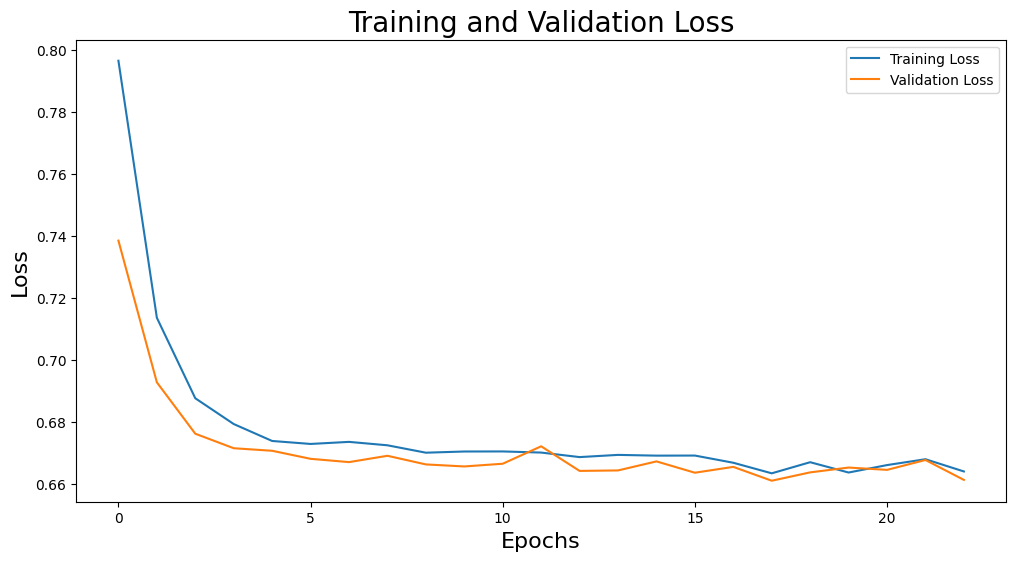

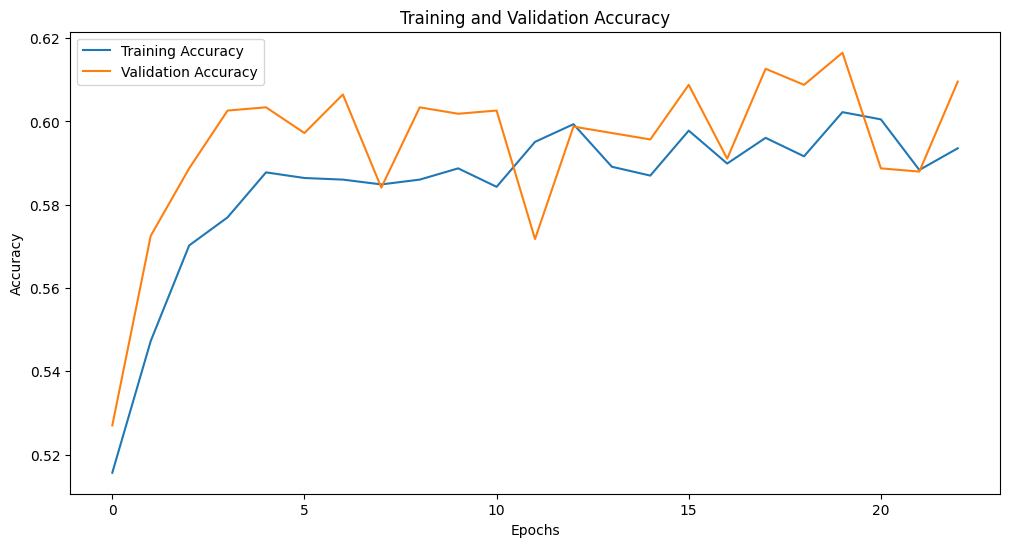

Test Loss: 0.6702
Test Accuracy: 0.5981


In [48]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs', size = 16)
plt.ylabel('Loss', size = 16)
plt.title('Training and Validation Loss', size = 20)
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


In [54]:
billboard_features_df['predicted_like'] = model.predict(billboard_features_df[features])
top_recommendations = billboard_features_df.sort_values(by='predicted_like', ascending=False).head(10)
top_recommendations[['title', 'all_artists', 'predicted_like']]

4/4 [==============================] - 0s 5ms/step


,title,all_artists,predicted_like
43,Never Lose Me,Flo Milli,0.677871
26,Type Shit,"Future, Metro Boomin, Travis Scott, Playboi Carti",0.676404
96,"One Of The Girls (with JENNIE, Lily Rose Depp)","The Weeknd, JENNIE, Lily-Rose Depp",0.674075
71,Bandit,Don Toliver,0.671483
2,euphoria,Kendrick Lamar,0.670361
19,I Remember Everything (feat. Kacey Musgraves),"Zach Bryan, Kacey Musgraves",0.669945
84,Outskirts,Sam Hunt,0.668655
15,Down Bad,Taylor Swift,0.668554
8,Beautiful Things,Benson Boone,0.667966
16,Push Ups,Drake,0.665889


In [56]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose = 0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

Test Loss: 0.6702
Test Accuracy: 0.5981
Train Accuracy: 0.6083


In [55]:
billboard_features_df[features] = scaler.transform(billboard_features_df[features])

# Predict the popularity of Billboard songs
predictions = model.predict(billboard_features_df[features])

# Add predictions to the DataFrame
billboard_features_df['predicted_popularity'] = predictions

# Recommend the top 10 songs based on predicted popularity
top_10_recommendations = billboard_features_df.nlargest(10, 'predicted_popularity')
top_10_recommendations[['title', 'all_artists', 'predicted_popularity']]

4/4 [==============================] - 0s 4ms/step


,title,all_artists,predicted_popularity
43,Never Lose Me,Flo Milli,0.679073
26,Type Shit,"Future, Metro Boomin, Travis Scott, Playboi Carti",0.677588
96,"One Of The Girls (with JENNIE, Lily Rose Depp)","The Weeknd, JENNIE, Lily-Rose Depp",0.675264
71,Bandit,Don Toliver,0.673142
2,euphoria,Kendrick Lamar,0.671725
19,I Remember Everything (feat. Kacey Musgraves),"Zach Bryan, Kacey Musgraves",0.670969
84,Outskirts,Sam Hunt,0.669854
15,Down Bad,Taylor Swift,0.669581
8,Beautiful Things,Benson Boone,0.668866
16,Push Ups,Drake,0.667559


# Convolutional Neural Network Application

In [169]:
X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)

In [170]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define the CNN architecture
model_cnn = Sequential([
    Conv1D(32, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(64, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


Epoch 1/50
162/162 [==============================] - 1s 6ms/step - loss: 0.6793 - accuracy: 0.5666 - val_loss: 0.6814 - val_accuracy: 0.5656
Epoch 2/50
162/162 [==============================] - 1s 4ms/step - loss: 0.6794 - accuracy: 0.5660 - val_loss: 0.6763 - val_accuracy: 0.5772
Epoch 3/50
162/162 [==============================] - 1s 4ms/step - loss: 0.6802 - accuracy: 0.5615 - val_loss: 0.6819 - val_accuracy: 0.5664
Epoch 4/50
162/162 [==============================] - 1s 3ms/step - loss: 0.6789 - accuracy: 0.5623 - val_loss: 0.6807 - val_accuracy: 0.5694
Epoch 5/50
162/162 [==============================] - 1s 3ms/step - loss: 0.6788 - accuracy: 0.5681 - val_loss: 0.6768 - val_accuracy: 0.5694
Epoch 6/50
162/162 [==============================] - 1s 4ms/step - loss: 0.6753 - accuracy: 0.5748 - val_loss: 0.6767 - val_accuracy: 0.5694
Epoch 7/50
162/162 [==============================] - 1s 3ms/step - loss: 0.6776 - accuracy: 0.5681 - val_loss: 0.6742 - val_accuracy: 0.5818
Epoch 

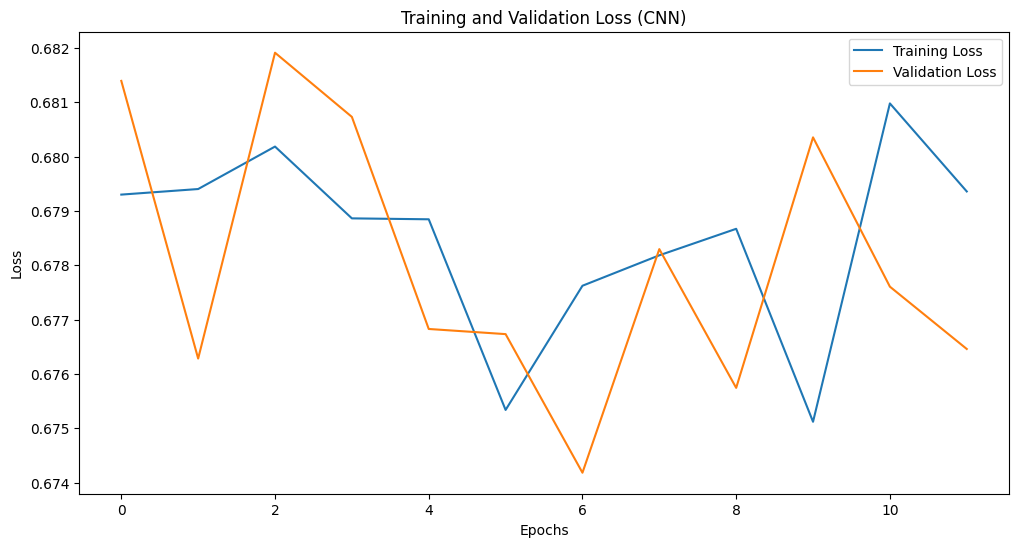

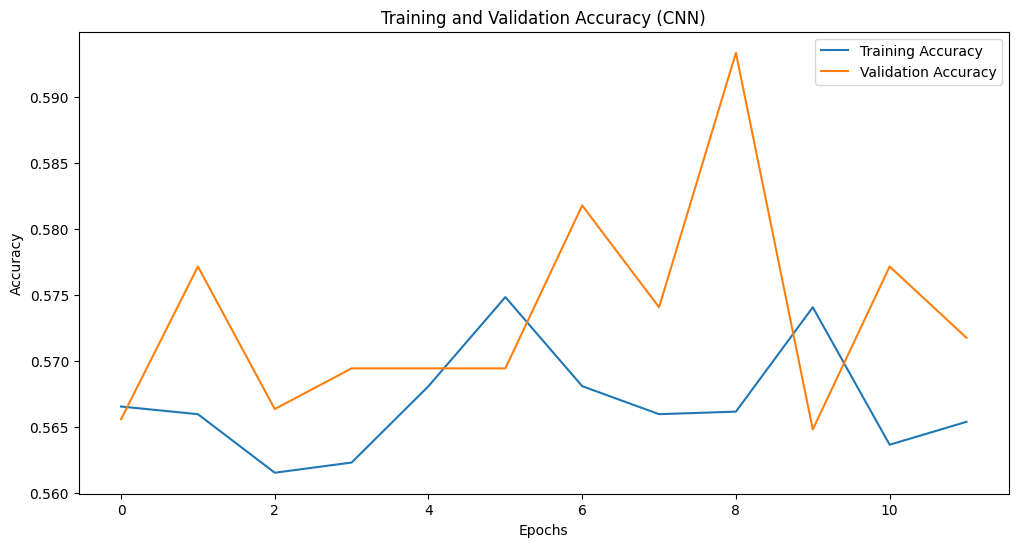

Test Loss (CNN): 0.6747
Test Accuracy (CNN): 0.5728


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- energy
Feature names seen at fit time, yet now missing:
- duration_ms
- time_signature


In [172]:
# Train the model
history_cnn = model_cnn.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (CNN)')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (CNN)')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(X_test_cnn, y_test, verbose=0)

print(f"Test Loss (CNN): {test_loss_cnn:.4f}")
print(f"Test Accuracy (CNN): {test_accuracy_cnn:.4f}")

# Making predictions and getting top recommendations
billboard_features_df[features] = scaler.transform(billboard_features_df[features])
billboard_features_cnn = np.expand_dims(billboard_features_df[features], axis=2)
billboard_features_df['predicted_like_cnn'] = model_cnn.predict(billboard_features_cnn)
top_recommendations_cnn = billboard_features_df.sort_values(by='predicted_like_cnn', ascending=False).head(10)
print(top_recommendations_cnn[['title', 'all_artists', 'predicted_like_cnn']])
